In [1]:
import pandas as pd
import wandb

runs = pd.read_csv("wandb_export_2024-05-16T08_43_58.520+01_00.csv")

from tqdm.auto import tqdm
api = wandb.Api(timeout=29)

for i, r in tqdm(runs.iterrows(), total=len(runs)):
    if r.State in ['failed', 'crashed']: 
        if r.Runtime 
        try:
            run = api.run(f"smonaco/rainfall/{r.ID}")
            run.delete()
        except:
            print(f"Failed to delete {r.ID}")

<Axes: xlabel='Runtime', ylabel='Count'>

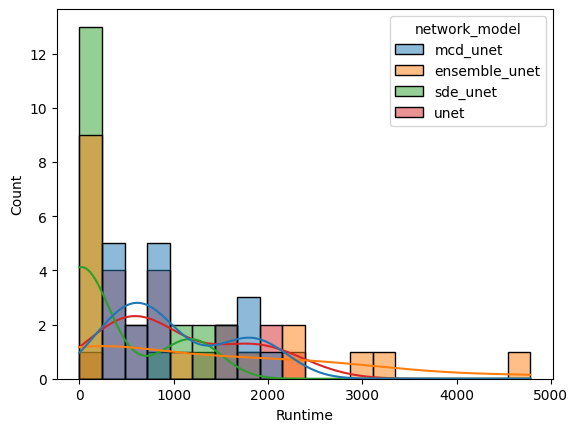

In [4]:
import seaborn as sns

sns.histplot(data=runs, x='Runtime', hue='network_model', bins=20, kde=True)

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import io

In [6]:
splitdir = Path("/media/monaco/DATA1/case_study/24h_10mmMAX_OI/split")
convective = pd.read_csv(splitdir / "cluster_convective.csv", sep=";")
intermediate = pd.read_csv(splitdir / "cluster_intermediate.csv", sep=";")
stratiform = pd.read_csv(splitdir / "cluster_stratiform.csv", sep=";")

dates = pd.concat([
    convective.assign(NAME="convective"),
    intermediate.assign(NAME="intermediate"),
    stratiform.assign(NAME="stratiform")
])

In [7]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=9, random_state=42, shuffle=True)
n_split = 2
train_index, test_index = list(skf.split(dates, dates.NAME))[n_split]
val_index, train_index = np.split(train_index, [len(test_index)])

print(len(train_index), len(val_index), len(test_index))

314 45 45


# Result analysis

In [7]:
respath = Path("lightning_logs")
for model in respath.glob("[!_]*"):
    for split in model.glob("split_*"):
        for predpath in (split / "test_images").glob("_pred.png"):
            pred = Image.open(predpath).convert("L")

lightning_logs/unet/split_5
lightning_logs/unet/split_3
lightning_logs/ensemble_unet/split_1
lightning_logs/ensemble_unet/split_3
lightning_logs/sde_unet/split_5
lightning_logs/sde_unet/split_3


Out-of-distribution detection for regression on the dataset, where OoD are some extreme events hidden at train time.
We report the average performance and standard deviation for 9 random splits. All the  model performance is compared in terms of RMSE, AUROC, and AUPR.

In [ ]:
# PAY ATTENTION THAT THIS IS DONE FOR THE n REPETITIONS OF THE PROBABILISTIC MODEL, EACH RETURNING A METRIC VALUE OVER WHICH WE CALCULATE THE MEAN AND STD
import torch

def calc_RMSE(pred_mean: torch.Tensor, pred_variance: torch.Tensor, target_img: torch.Tensor) -> float:
    """
    preds_mean and pred_std have shape (N, 1, H, W), target has shape (N, 1, H, W)
    """
    return torch.sqrt(((pred_mean - target_img) ** 2).mean())

def calc_AUROC(pred_mean: torch.Tensor, pred_variance: torch.Tensor, target: torch.Tensor) -> float:
    """
    preds_mean and pred_std have shape (N, 1, H, W), target has shape (N) and is a binary tensor saying if the nth event is an OoD one
    AUROC is calculated assigning a label to each prediction based on the average variance over all the pixels of the image
    """
    avg_variance = pred_variance.mean(dim=(1, 2, 3))
    curve_steps = 1000
    auroc = 0
    fprTemp = 1
    for delta in torch.arange(avg_variance.min(), avg_variance.max(), (avg_variance.max() - avg_variance.min()) / curve_steps):
        tpr = (avg_variance > delta).float().eq(target).float().mean()
        fpr = (avg_variance > delta).float().ne(target).float().mean()
        auroc += (fprTemp - fpr) * tpr
        fprTemp = fpr

def calc_AUPR_out(pred_mean: torch.Tensor, pred_variance: torch.Tensor, target: torch.Tensor) -> float:
    """
    preds_mean and pred_std have shape (N, 1, H, W), target has shape (N) and is a binary tensor saying if the nth event is an OoD one
    AUPR is calculated assigning a label to each prediction based on the average variance over all the pixels of the image
    """
    avg_variance = pred_variance.mean(dim=(1, 2, 3))
    curve_steps = 1000
    aupr = 0
    recallTemp = 1
    for delta in torch.arange(avg_variance.min(), avg_variance.max(), (avg_variance.max() - avg_variance.min()) / curve_steps):
        precision = (avg_variance > delta).float().ne(target).float().mean()
        recall = (avg_variance > delta).float().ne(target).float().mean()
        aupr += (recallTemp - recall) * precision
        recallTemp = recall

def calc_AUPR_in(pred_mean: torch.Tensor, pred_variance: torch.Tensor, target: torch.Tensor) -> float:
    target = target.eq(0).float()
    return calc_AUPR_out(pred_mean, pred_variance, target)

In [ ]:
num_repetitions = 5

from training import get_model

for model in ['unet', 'sde_unet', 'ensemble_unet', 'mcd_unet']:
    for split in range(9):
        checkpoint_path = f"lightning_logs/{model}/split_{split}/"
        if not checkpoint_path.exists():
            continue
        model = get_model(model).load_from_checkpoint(next(checkpoint_path.glob("*.ckpt")))

In [ ]:
from typing import Any
from easydict import EasyDict as edict
import torch

class Metrics:
    def __init__(self):
        self.models = []
        self.metrics = edict()
    
    def __call__(self, y_true, y_pred, model=None, split=None, **kwargs):
        if model not in self.models:
            self.models.append(model)
            self.metrics[model] = edict()
            self.metrics[model][split] = self.metric_func(y_true, y_pred, **kwargs)
        else:
            if split not in self.metrics[model]:
                self.metrics[model][split] = self.metric_func(y_true, y_pred, **kwargs)
            else:
                raise ValueError(f"Model {model} and split {split} already exists")
            

class RMSE(Metrics):
    def metric_func(self, y_true, y_pred):
        if isinstance(y_true, torch.Tensor):
            y_true = y_true.cpu().numpy()
        if isinstance(y_pred, torch.Tensor):
            y_pred = y_pred.cpu().numpy()
        return np.sqrt(np.mean((y_true - y_pred) ** 2))

class AUROC(Metrics):
    def metric_func(self, y_true, y_pred, isother=None):
        # isother is a bool array saying for each sample if it is OoD
        if isinstance(y_true, torch.Tensor):
            y_true = y_true.cpu().numpy()
        if isinstance(y_pred, torch.Tensor):
            y_pred = y_pred.cpu().numpy()
        


In [ ]:
out_of_class_dl = RainDataset() # contains image and ground truth of the OoD samples
out_of_class_dl = DataLoader(out_of_class_dl, batch_size=1, shuffle=False)

all_models = {
    'unet': [...],
    'mcd_unet': [...],
    'sde_unet': [...],

}
# This dictionary contains the models trained for each split in a list



for batch_id, data in enumerate(out_of_class_dl):
    image, target_img = data
    image = image.to(device)
    target_img = target_img.to(device)
    for model in all_models:
        for i, mi in enumerate(all_models[model]):
            mi.eval()
            with torch.no_grad():
                output = mi(image) # regression image of dimensions equal to the target
                RMSE.update(output, target_img, model=model, split=i)
                AUROC.update(output, target_img, model=model, split=i)
                AUPRC.update(output, target_img, model=model, split=i)
                MAE.update(output, target_img, model=model, split=i)
        AUROC.aggregate(model=model)
        AUPRC.aggregate(model=model)
        

            


# Xtreme events

In [8]:
input_path = Path('/media/monaco/DATA1/case_study')
n_split = 8
case_study = '24h_10mmMAX_OI'
input_path = input_path / case_study
use_extreme = False

case_study_max, available_models, train_dates, val_dates, test_dates, indices_one, indices_zero, mask, nx, ny = io.get_casestudy_stuff(
    input_path, n_split, case_study=case_study, ispadded=True,
    seed=42
)

print(len(train_dates), len(val_dates), len(test_dates), sum(len(x) for x in [train_dates, val_dates, test_dates]))

from sklearn.model_selection import train_test_split
test_dates1 = pd.concat([pd.read_csv(exev, header=None) for exev in input_path.glob('*extremeEvents.csv')])[0].values
train_dates = np.array(list(set(train_dates).union(val_dates).union(test_dates).difference(test_dates1)))
train_dates, val_dates = train_test_split(train_dates, train_size=315, random_state=42)
test_dates = test_dates1
print(len(train_dates), len(val_dates), len(test_dates), sum(len(x) for x in [train_dates, val_dates, test_dates])-17)




x_train, y_train, in_features, out_features = io.load_data(input_path, train_dates, case_study_max, indices_one, indices_zero, available_models)
x_val, y_val, in_features, out_features = io.load_data(input_path, val_dates, case_study_max, indices_one, indices_zero, available_models)
x_test, y_test, in_features, out_features = io.load_data(input_path, test_dates, case_study_max, indices_one, indices_zero, available_models)

315 45 45 405
315 59 48 405


AssertionError: File /media/monaco/DATA1/case_study/24h_10mmMAX_OI/models/bol00_20220606_0024_regrid.csv does not exist

In [14]:
for n, sp in zip(['tr', 'vl', 'ts'], [train_dates, val_dates, test_dates]):
    print(n)
    for d in sp:
        if not Path(f"/media/monaco/DATA1/case_study/24h_10mmMAX_OI/models/bol00_{d}_0024_regrid.csv").exists():
            print('>>', d)

tr
vl
ts
>> 20220606
>> 20220701
>> 20220727
>> 20220809
>> 20220906
>> 20220909
>> 20220928
>> 20221001
>> 20221223
>> 20230413
>> 20230516
>> 20230703
>> 20230825
>> 20230912
>> 20231113
>> 20231114
>> 20240318
